# Classification Data Preparation
**Mudgee NSW - Change Detection Jan 2005 to Jan 2024**

Author: Michael Dear, May 2024

This notebook adds classification variables to the dataset.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [2]:
from global_params import *

# Random state for reproducibility
random_state = 11

y_var = ['class']

## Step 1: Load data

In [3]:
ds = xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [4]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [5]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [6]:
# Put the period names in a list for convenience.
periods = list(ds.period.values)
periods

['Jul 2015', 'Jul 2023']

## Step 2: Classification

### Ground-truth Points (GTP)
The process is:
1. Create polygons for each class using QGIS, Google Earth, and composite plots for each period.
2. Intersect the polygons with the data array to create a candidate set of points for each period.
3. Reduce the candidate set in each class to the size of the smallest class.
4. Train the classifier.
5. Predict.

See https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe for converting a data array to points.

In [187]:
# Read in the labelled polygons
gtp_polys = [gpd.read_file(vector_dir+'gtp_polygons_'+str(i)+'.geojson').to_crs(crs) for i in [0,1]]

In [188]:
for i in [0,1]:
    print(gtp_polys[i].head())

   class_num    class_name                                           geometry
0          0          Bare  MULTIPOLYGON (((1882206.535 -3220815.918, 1882...
1          1         Grass  MULTIPOLYGON (((1876057.375 -3231564.132, 1876...
2          2  Sparse Woody  MULTIPOLYGON (((1893559.363 -3221048.426, 1894...
3          3   Dense Woody  MULTIPOLYGON (((1895709.035 -3207608.748, 1896...
   class_num    class_name                                           geometry
0          0          Bare  MULTIPOLYGON (((1894253.644 -3220846.010, 1894...
1          1         Grass  MULTIPOLYGON (((1876057.375 -3231564.132, 1876...
2          2  Sparse Woody  MULTIPOLYGON (((1893559.363 -3221048.426, 1894...
3          3   Dense Woody  MULTIPOLYGON (((1895709.035 -3207608.748, 1896...


In [176]:
for i in [0,1]:
    gtp_polys[i]['geometry'] = gtp_polys[i].buffer(-spatial_res)
    print(gtp_polys[i].head())

   class_num    class_name                                           geometry
0          0          Bare  MULTIPOLYGON (((1891792.999 -3238747.786, 1891...
1          1         Grass  MULTIPOLYGON (((1895989.219 -3224376.588, 1896...
2          2  Sparse Woody  MULTIPOLYGON (((1896041.478 -3222720.746, 1896...
3          3   Dense Woody  MULTIPOLYGON (((1900356.543 -3219429.489, 1901...
   class_num    class_name                                           geometry
0          0          Bare  MULTIPOLYGON (((1900241.394 -3221695.311, 1900...
1          1         Grass  MULTIPOLYGON (((1895989.219 -3224376.588, 1896...
2          2  Sparse Woody  MULTIPOLYGON (((1896041.478 -3222720.746, 1896...
3          3   Dense Woody  MULTIPOLYGON (((1900356.543 -3219429.489, 1901...


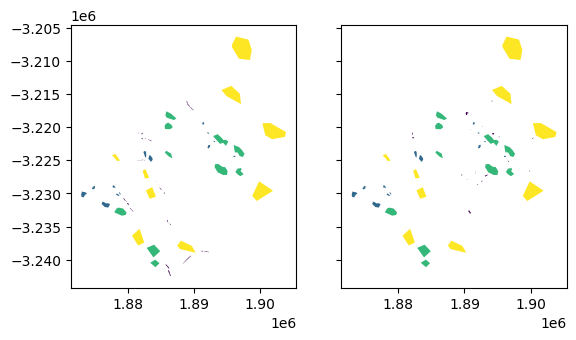

In [190]:
# Plot to check the data
fig, axes = plt.subplots(1,2, sharey=True)
for i in [0,1]:
    unq_nums = np.unique(gtp_polys[i]['class_num'])
    gtp_polys[i].plot(ax=axes[i], column='class_num')

In [178]:
X_vars = list(ds.data_vars.keys())[:8]
X_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR']

In [191]:
gtp_base = [[],[]]

for i in [0,1]:
    # Convert the data array to a data frame
    df = ds.isel(period=i).to_dataframe().reset_index()
    
    # Convert to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y)).set_crs(crs)

    # Add internal buffer
    # gdf['geometry'] = gdf.buffer(-(spatial_res/2))
    
    # Intersect the points with the polygons
    gdf = gpd.sjoin(gdf, gtp_polys[i], how='inner') # Limit to polygon
    gtp_base[i] = gdf[X_vars+['class_num','class_name','geometry']]


In [192]:
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i].head())
    print('--------------')

Period: 0
        nbart_red  nbart_blue  nbart_green  nbart_nir  nbart_swir_1  \
247657      373.0       227.0        320.0     1578.0        1429.0   
247658      393.0       224.0        326.0     1478.0        1354.0   
247659      353.0       204.0        300.0     1403.0        1291.0   
247660      383.0       240.0        317.0     1441.0        1422.0   
248861      373.0       227.0        320.0     1578.0        1429.0   

        nbart_swir_2      NDVI       NBR  class_num   class_name  \
247657         780.0  0.617632  0.338422          3  Dense Woody   
247658         775.0  0.579904  0.312028          3  Dense Woody   
247659         737.0  0.597950  0.311215          3  Dense Woody   
247660         813.0  0.580044  0.278616          3  Dense Woody   
248861         780.0  0.617632  0.338422          3  Dense Woody   

                                geometry  
247657  POINT (1896345.000 -3206355.000)  
247658  POINT (1896375.000 -3206355.000)  
247659  POINT (1896405.00

In [193]:
# Count the number of points in each class
for i in [0,1]:
    print('Period:', i)
    print(gtp_base[i]['class_num'].value_counts())
    print('--------------')


Period: 0
class_num
3    32769
2    14123
1     2734
0      944
Name: count, dtype: int64
--------------
Period: 1
class_num
3    32769
2    14123
1     2734
0      580
Name: count, dtype: int64
--------------


In [194]:
# Reduce each class to the size of the smallest class
sample_size = np.min([gtp_base[i]['class_num'].value_counts().min() for i in [0,1]])

gtp_equal = [pd.concat([gtp_base[i][gtp_base[i]['class_num']==cl].sample(sample_size, random_state=random_state) 
                for cl in gtp_base[i]['class_num'].unique()], axis=0) 
                for i in [0,1]]

In [195]:
# Count the number of points in each class
for i in [0,1]:
    print('Period:', i)
    print(gtp_equal[i]['class_num'].value_counts())
    print('--------------')


Period: 0
class_num
3    580
0    580
2    580
1    580
Name: count, dtype: int64
--------------
Period: 1
class_num
3    580
0    580
2    580
1    580
Name: count, dtype: int64
--------------


### NDVI Classification

The following are typical NDVI thresholds based on the literature. These will need to be adjusted for each period from the results of the GTP analysis. 
|Class Number|Class Name|Class Description|Threshold|
|:-:|:-|:-|:-:|
|1|Water|Deep water bodies e.g. lakes, rivers|$$\text{NDVI} \lt 0$$|
|2|Bare|Bare ground|$$0 \le \text{NDVI} \lt 0.15$$|
|3|Sparse|Sparse vegetation e.g. scattered shrubs, patchy grass|$$0.15 \le \text{NDVI} \lt 0.5$$|
|4|Medium-density|Medium-density vegetation e.g. woodland; post-fire regrowth|$$0.5 \le \text{NDVI} \lt 0.8$$|
|5|High-density|Dense vegetation e.g. forest|$$\text{NDVI} \ge 0.8$$|
|6|Masked|No data|nan|

The thresholds were derived from the following sources:

* [Map Information - Normalised Difference Vegetation Index: Australian Bureau of Meterology](http://www.bom.gov.au/climate/austmaps/about-ndvi-maps.shtml)
* [NDVI, the Foundation for Remote Sensing Phenology : USGS](https://www.usgs.gov/special-topics/remote-sensing-phenology/science/ndvi-foundation-remote-sensing-phenology)

#### GTP Analysis

In [196]:
# Summarise by Class
for i in [0,1]:
    print('Period:', i)
    print(gtp_equal[i].groupby('class_num').agg({'NDVI':['min','max','mean','median']}))
    print('----------')

Period: 0
               NDVI                              
                min       max      mean    median
class_num                                        
0         -0.020504  0.650565  0.337396  0.342495
1          0.311234  0.713788  0.416698  0.414369
2          0.281869  0.694319  0.454255  0.444419
3          0.437548  0.780398  0.667935  0.672186
----------
Period: 1
               NDVI                              
                min       max      mean    median
class_num                                        
0         -0.051944  0.493874  0.049288  0.028270
1          0.172414  0.570594  0.311761  0.300689
2          0.197394  0.699352  0.407281  0.397622
3          0.485422  0.779855  0.660284  0.665785
----------


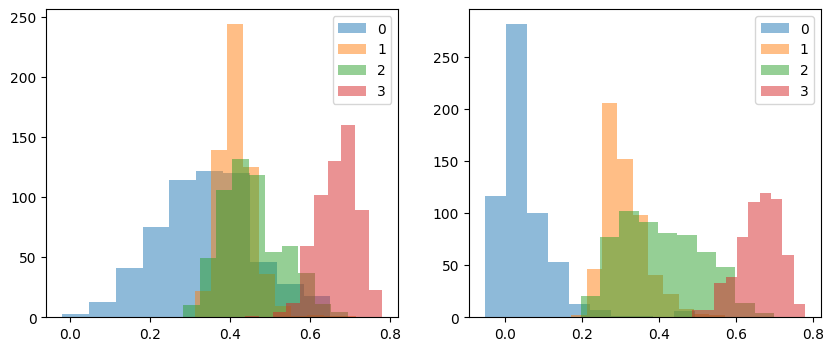

In [197]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

for i in [0,1]:
    cl_nums = np.sort(gtp_equal[i]['class_num'].unique())
    for cl in cl_nums:
        axes[i].hist(gtp_equal[i]['NDVI'][gtp_equal[i]['class_num']==cl], alpha=0.5)
    
    axes[i].legend(cl_nums)

#### Create the NDVI classification dataset
<a id='create_classification'></a>

In [83]:
# Function to make threshold classification variable
# See https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_calculate_classify_ndvi.html for np.digitize
# See https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html for assigning numpy array to a dataset

# Needed to set the order of the dims explicitly in this case - not the same as ds.dims
def make_class_var(ds, class_bins, var, newvar):
    class_arr = np.empty(ds[var].values.shape)
    
    class_arr = [np.digitize(ds[var].sel(period=period), class_bins[i]).astype(np.int16) 
     for i, period in enumerate(ds.period.values)]

    # Subtract 1 from class values to align with other classification methods
    class_arr = np.array(class_arr)-1
    
    # ds = ds.assign({newvar: (('period','y','x'), class_arr)})
    # return ds
    
    return class_arr

In [215]:
# Use mean or median for first n-2 classes
# Use the minimum of the nth class as the upper bound of the (n-1)th class
# No upper bound required for the nth class (it is np.inf)
NDVI_class_bins = [
    [-np.inf, 0.19, 0.5, np.inf],
    [-np.inf, 0.19, 0.5, np.inf]
]

In [216]:
class_arr = make_class_var(ds, class_bins = NDVI_class_bins, var='NDVI', newvar='NDVI_Class')
ds = ds.assign({'NDVI_Class': (('period','y','x'), class_arr)})

In [217]:
# Check unique classes present
np.unique(ds.NDVI_Class)

array([0, 1, 2], dtype=int16)

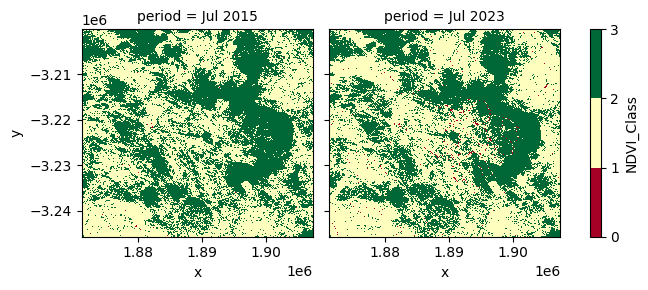

In [218]:
# Plot of NDVI_Class
ds.NDVI_Class.plot(col='period', 
                   cmap='RdYlGn', 
                   levels = np.arange(len(np.unique(ds.NDVI_Class))+1)
                  )

### Kmeans Classification
Based on https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/

#### Create the normalised dataframe

In [89]:
list(gtp_equal.columns)

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'class_num',
 'class_name',
 'geometry']

In [91]:
# Select the variables to use in the classification
km_vars = [list(gtp_equal.columns)[i] for i in [0,2,3,5]]

df = pd.DataFrame(gtp_equal[km_vars])

from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()

x = df[km_vars].values # returns a numpy array
x_norm = scaler.fit_transform(x)
df[km_vars] = x_norm
df.head()

,nbart_red,nbart_green,nbart_nir,nbart_swir_2
812531,-1.033409,-0.962205,-0.924826,-1.482832
1218848,-0.864422,-0.760814,-0.690431,-1.222319
576353,-0.910630,-0.865353,-1.084547,-0.992527
1455988,-0.930433,-0.765426,-0.839780,-1.228463
1489909,-0.868383,-0.751590,-0.937272,-1.065028


#### Determine best K
See https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method

In [93]:
from sklearn.cluster import KMeans

In [44]:
# Array to hold the final classifications
km_arrs = [[] for i in [0,1]]

In [65]:
ds.sizes

Frozen({'y': 1518, 'x': 1204, 'period': 2})

In [66]:
# Sizes for reshaping flattened arrays
w = ds.sizes['y']
l = ds.sizes['x']

In [94]:
ks = np.arange(1,8)

# Set random_state for reproducibility
km = [KMeans(n_clusters=k, random_state = random_state) for k in ks]

In [95]:
scores = [k.fit(df).score(df) for k in km]

In [101]:
print(ks)
print(scores)

[1 2 3 4 5 6 7]
[-9279.9990234375, -4211.56298828125, -2639.132568359375, -1767.0361328125, -1363.448486328125, -1051.9227294921875, -914.8779296875]


Text(0, 0.5, 'Score')

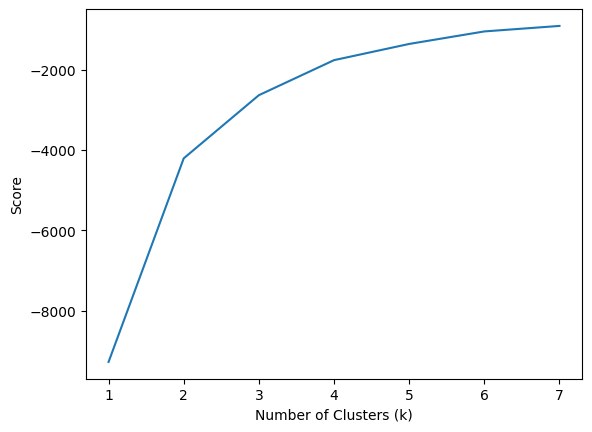

In [102]:
fig, ax = plt.subplots()
ax.plot(ks, scores)
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Score')

----

#### Option 1: Fit on Period 0; predict on Period 1

In [312]:
km = KMeans(n_clusters=5, random_state = random_state)
km_arrs[0] = (km.fit(df.loc[periods[0]])
        .labels_
        .reshape(w,l)
       )

In [313]:
km_arrs[1] = (km.predict(df.loc[periods[1]])
        .reshape(w,l)
       )

----

#### Option 2: Fit on both periods separately

In [128]:
ks = [3,4]
for i, k in enumerate(ks):
    km = KMeans(n_clusters=k, random_state = random_state)
    km_arrs[i] = km.fit(df.loc[periods[i]]).labels_.reshape(w,l)

----

#### Either Option: Plot to check the data

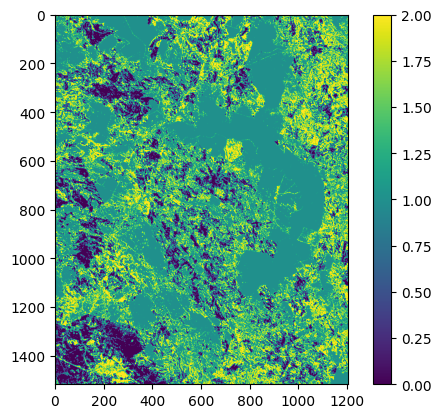

In [129]:
plt.imshow(km_arrs[0])
plt.colorbar()

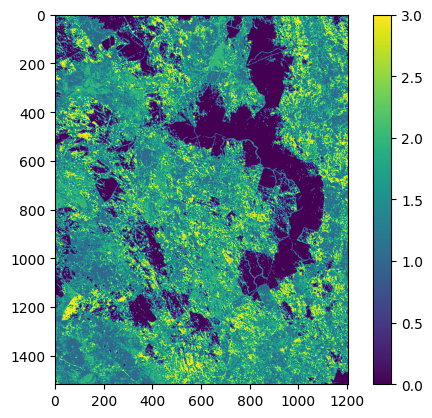

In [130]:
plt.imshow(km_arrs[1])
plt.colorbar()

#### Add the classification data to the dataset

In [70]:
# Convert to int16
km_arrs = np.array(km_arrs, dtype=np.int16)

In [71]:
ds = ds.assign({'Kmeans_Class': (('period','y','x'), km_arrs)})

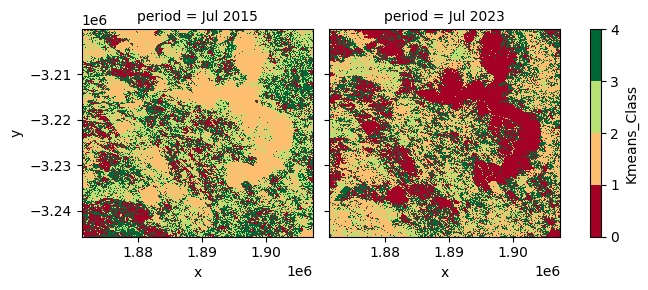

In [72]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

#### Re-code Classes (Optional)


In [76]:
old_vals = np.array(km_arrs)

In [77]:
new_vals = np.empty(old_vals.shape)
new_vals.shape

(2, 1518, 1204)

In [94]:
# Use the same re-code values for both periods if using Option 1.
recode = (
    [(0,0),(1,3),(2,2),(3,1)],
    [(0,3),(1,0),(2,1),(3,2)]
)

In [95]:
for i in [0,1]:
    for j in np.arange(len(np.unique(old_vals[i]))):
        new_vals[i][old_vals[i]==recode[i][j][0]] = recode[i][j][1]

In [96]:
ds.Kmeans_Class.values = new_vals

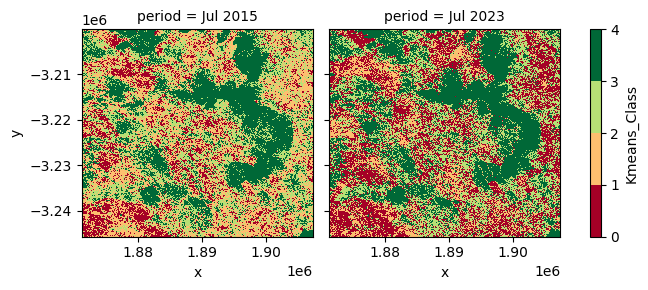

In [97]:
ds.Kmeans_Class.plot(col='period', 
                     levels=np.arange(len(np.unique(ds.Kmeans_Class))+1),
                     cmap='RdYlGn')

## Step 3: Random Forest
Based on
* https://www.datacamp.com/tutorial/random-forests-classifier-python
* https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial

#### Imports

In [158]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#### Create the training and test sets

In [13]:
rf_vars = [list(ds.data_vars.keys())[i] for i in [5,6,7]]

In [278]:
X = [gdf[rf_vars] for gdf in gtp]
y = [gdf[y_var] for gdf in gtp]

In [279]:
for i in [0,1]:
    print(X[i][:5])
    print(y[i][:5])

   nbart_red  nbart_green  nbart_blue  nbart_nir
0      444.5        337.0       177.0     1863.0
1      444.5        337.0       177.0     1863.0
2      471.0        429.0       227.5     1901.5
3      471.0        429.0       227.5     1901.5
4      416.5        379.5       165.5     2399.0
   class
0      3
1      3
2      3
3      3
4      3
   nbart_red  nbart_green  nbart_blue  nbart_nir
0      310.0        294.5       153.0     2274.5
1      310.0        294.5       153.0     2274.5
2     1272.5        972.5       578.0     2460.5
3     1272.5        972.5       578.0     2460.5
4      382.0        443.0       204.0     2570.5
   class
0      2
1      2
2      0
3      0
4      2


#### Basic RF

In [280]:
for i in [0,1]:
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
    rf = RandomForestClassifier(random_state=random_state)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(periods[i])
    print('============')
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Aug-Nov 2004
Accuracy: 1.0

Feature Importance
nbart_green    0.291050
nbart_blue     0.258008
nbart_nir      0.229355
nbart_red      0.221587
dtype: float64

Confusion matrix
[[5 0 0 0 0]
 [0 3 0 0 0]
 [0 0 4 0 0]
 [0 0 0 2 0]
 [0 0 0 0 6]]

Aug-Nov 2022
Accuracy: 1.0

Feature Importance
nbart_nir      0.278674
nbart_green    0.264020
nbart_blue     0.245073
nbart_red      0.212233
dtype: float64

Confusion matrix
[[7 0 0 0 0]
 [0 3 0 0 0]
 [0 0 1 0 0]
 [0 0 0 3 0]
 [0 0 0 0 6]]



#### RF With Hyperparameter Tuning

In [228]:
# List to hold the trained classifiers
rfs = []

for i in [0,1]:
    # Create the parameter grid
    param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

    # Create a random forest classifier
    rf = RandomForestClassifier(random_state=random_state)
    
    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf, 
                                     param_distributions = param_dist, 
                                     n_iter=5, 
                                     cv=5)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=random_state)
   
    # Fit the random_search to the data
    rand_search.fit(X_train, y_train)

    # Store the best model
    best_rf = rand_search.best_estimator_

    # Predict
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Append best model to list
    rfs.append(best_rf)

    print(periods[i])
    print('============')
    # print('y_test:', y_test['class'].values)
    # print('y_pred:', y_pred)
    print("Accuracy:", accuracy)
    print()

    # List the importance of features
    print('Feature Importance')
    feature_scores = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print(feature_scores)
    print()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix')
    print(cm)
    print()

Aug-Nov 2004
Accuracy: 1.0

Feature Importance
nbart_green    0.299678
nbart_blue     0.261814
nbart_nir      0.228207
nbart_red      0.210301
dtype: float64

Confusion matrix
[[3 0 0 0 0]
 [0 5 0 0 0]
 [0 0 4 0 0]
 [0 0 0 2 0]
 [0 0 0 0 6]]

Aug-Nov 2022
Accuracy: 1.0

Feature Importance
nbart_green    0.284351
nbart_nir      0.280958
nbart_blue     0.230576
nbart_red      0.204115
dtype: float64

Confusion matrix
[[3 0 0 0 0]
 [0 7 0 0 0]
 [0 0 1 0 0]
 [0 0 0 3 0]
 [0 0 0 0 6]]



#### Predictions for each period

In [281]:
rf_arrs = [[] for i in [0,1]]

In [282]:
w = list(ds.sizes.values())[1]
l = list(ds.sizes.values())[2]

In [286]:
rf_arrs = [rfs[i].predict(ds.sel(period=periods[i]).to_dataframe()[rf_vars].values).reshape(w,l) for i, period in enumerate(periods)]

#### Add the classification data to the dataset

In [287]:
ds = ds.assign({'RF_Class': (('period','y','x'), rf_arrs)})

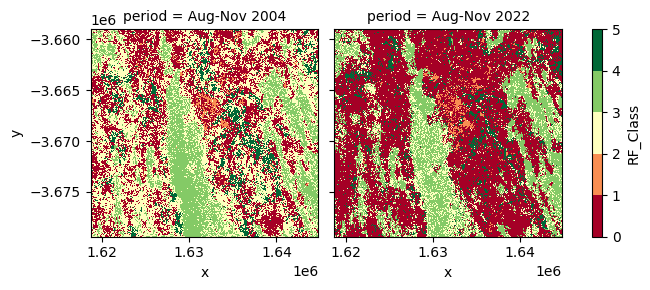

In [288]:
ds.RF_Class.plot(col='period', 
                 levels=np.arange(len(np.unique(ds.RF_Class))+1),
                 cmap='RdYlGn')

## Step 4: Export data 

### netCDF

In [11]:
# Save as netCDF
ds.to_netcdf(netcdf_dir+study_area_abbrev+'.nc')

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [12]:
for period in ds.period.values:
     (ds
     .sel(period=period)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'.tiff')
     )

In [13]:
ds

<xarray.Dataset>
Dimensions:       (y: 1518, x: 1204, period: 2)
Coordinates:
  * y             (y) float64 -3.2e+06 -3.2e+06 ... -3.246e+06 -3.246e+06
  * x             (x) float64 1.871e+06 1.871e+06 ... 1.907e+06 1.907e+06
    spatial_ref   int32 3577
  * period        (period) <U8 'Jul 2015' 'Jul 2023'
Data variables:
    nbart_red     (period, y, x) float32 532.0 447.0 442.0 ... 448.0 381.0 351.0
    nbart_blue    (period, y, x) float32 328.0 286.0 302.0 ... 224.0 180.0 175.0
    nbart_green   (period, y, x) float32 470.0 410.0 417.0 ... 367.0 336.0 297.0
    nbart_nir     (period, y, x) float32 2.131e+03 1.838e+03 ... 1.326e+03
    nbart_swir_1  (period, y, x) float32 1.773e+03 1.467e+03 ... 1.475e+03
    nbart_swir_2  (period, y, x) float32 998.0 821.0 820.0 ... 925.0 893.0
    NDVI          (period, y, x) float32 0.6005 0.6088 0.6168 ... 0.5804 0.5814
    NBR           (period, y, x) float32 0.3621 0.3825 0.3892 ... 0.2161 0.1951
    NDVI_Class    (period, y, x) int16 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2